<a href="https://colab.research.google.com/github/EIAmaury24/Reinforcement-Learning/blob/main/RL_preventive_maintenance_improvments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from collections import deque
import matplotlib.pyplot as plt

# Reinforcement Learning Example for Preventive Maintenance
## 1️⃣ Problem Description

In the semiconductor industry, production machines experience gradual wear and tear due to various factors such as temperature, vibrations, and pressure. Preventive maintenance is essential to avoid costly breakdowns.

The goal is to use Reinforcement Learning (RL) to learn an optimal maintenance strategy. The agent must decide when to perform maintenance in order to minimize costs and prevent failures

## Definition of RL Elements

### ✅ State:
The machine's state is represented as a vector of five continuous variables:

    Temperature (°C): [20,50]
    Vibrations (mm/s): [0.1,5]
    Pressure (bar): [1,5]
    Humidity (%): [30,50]
    Time since last maintenance (time units): [0,20]

### ✅ Actions:
The agent can choose between two actions:

    Action 0: Do nothing (the machine continues to operate).
    Action 1: Perform maintenance (resets the state to normal values).

### ✅ Reward:

    If the agent performs maintenance (Action 1) → -10 (negative reward).
    If the agent does not perform maintenance:
        If nothing happens, no reward
        If a failure occurs (temperature > 80°C, vibrations > 5, or more than 50 time units without maintenance) → -40 (high penalty).

### ✅ Agent’s Objective:
Maximize the cumulative reward by learning when to perform maintenance to prevent failures while minimizing costs.

## 3️⃣ Algorithm Used

The REINFORCE (Policy Gradient) algorithm is used to train the agent. The agent updates its policy based on the rewards obtained after each episode.

    Policy Model: Neural network with 5 inputs (state), one hidden layer (h_size=64), and 2 outputs (actions).
    Optimization: Adam algorithm with a learning rate of 1e-3.
    Discount factor reduction (gamma=0.9) to improve short-term learning.

# Final Summary:

The agent gradually learns an optimal preventive maintenance policy:

✅ It must anticipate failures and perform maintenance at the right time.

✅ It must avoid acting too frequently (unnecessary cost) or too late (critical failure).

✅ The RL approach helps optimize machine lifespan and productivity in a
semiconductor manufacturing plant.




In [ ]:
# Définition de l'environnement de maintenance préventive
class MaintenanceEnv:
    def __init__(self):
        self.reset()

    def reset(self):
        """Environment reset"""
        self.state = np.array([
            np.random.uniform(20, 25),  # Initial temperature
            np.random.uniform(0.1, 0.5),  # Initial Vibrations
            np.random.uniform(1, 1.5),  # Initial Pression
            np.random.uniform(30, 50),  # Initial humidity
            0  # Time since last maintenance
        ], dtype=np.float32)
        return self.state

    def step(self, action):
        """Status update based on agent action"""
        done = False
        reward = 0

        if action == 1:  # Maintenance carried out
          reward = -10
          self.state = np.array([
              np.random.uniform(20, 25),  # Temperature reset
              np.random.uniform(0.1, 0.5),  # Vibration reset
              np.random.uniform(1, 1.5),  # Regulated pressure
              np.random.uniform(30, 50),  # Humidity remains stable
              0  # Time since last maintenance reset
            ], dtype=np.float32)

        else:  # No maintenance
            self.state[0] += np.random.uniform(0.1, 2)  # Increase in temperature
            self.state[1] += np.random.uniform(0.05, 0.2)  # Increased vibrations
            self.state[2] += np.random.uniform(0.1, 0.3)  # Increase in pressure
            self.state[3] += np.random.uniform(-1, 1)  # Humidity fluctuates slightly
            self.state[4] += 1  # Time since last maintenance increase

            # Failure condition
            if self.state[0] > 50 or self.state[1] > 3 or self.state[4] > 20:
                reward = -40  # Large penalty for breakdowns
                self.state = np.array([
                    np.random.uniform(20, 25),  # Temperature reset
                    np.random.uniform(0.1, 0.5),  # Vibration reset
                    np.random.uniform(1, 1.5),  # Regulated pressure
                    np.random.uniform(30, 50),  # Humidity remains stable
                    0  # Time since last maintenance reset
                  ], dtype=np.float32)

        return self.state, reward, done

In [ ]:
# Définition du modèle de politique
class Policy(nn.Module):
    def __init__(self, s_size=5, h_size=16, a_size=2):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

    def act(self, state,epsilon = 0.1):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.forward(state)
        m = Categorical(probs)
        entropy = m.entropy()  # Compute the entropy
        action = m.sample()

        return action.item(), m.log_prob(action), entropy

# Initialisation de l'environnement et du modèle

env = MaintenanceEnv()
print('state:', env.state)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
policy = Policy().to(device)
optimizer = optim.RMSprop(policy.parameters(), lr=1e-2)

state: [22.844181    0.49864239  1.3780713  34.440292    0.        ]


In [ ]:
from re import escape
# Algorithme REINFORCE
def reinforce(n_episodes=1000, max_t=500, gamma=0.9, print_every=10):
    scores_deque = deque(maxlen=100)
    scores,avg_scores,t_table,action_0_table = [],[],[],[]
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        action_0 = 0
        for t in range(max_t):
            action, log_prob, entropy = policy.act(state)
            if action == 0:
                action_0 += 1
            saved_log_probs.append(log_prob)
            state, reward, done = env.step(action)
            rewards.append(reward)
            if done:
               break
        action_0_table.append(action_0)
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        if t <max_t:
            t_table.append((i_episode,t))

        # Calcul des récompenses cumulatives
        discounts = [gamma**i for i in range(len(rewards))]
        R = sum([a*b for a,b in zip(discounts, rewards)])

        policy_loss = []
        for log_prob in saved_log_probs:
            entropy_bonus = 0.01 * entropy
            policy_loss.append(-log_prob * R - entropy_bonus)
            #policy_loss.append(-log_prob * R)
        policy_loss = torch.cat(policy_loss).sum()

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if i_episode % print_every == 0:
            print(f'Episode {i_episode}\tAverage Score: {np.mean(scores_deque):.2f}')
            avg_scores.append(np.mean(scores_deque))

    return scores, avg_scores, t_table, action_0_table

# Exécution de l'entraînement
scores,avg_scores,t_table, action_0_table = reinforce()

Episode 10	Average Score: -935.00
Episode 20	Average Score: -926.00
Episode 30	Average Score: -924.00
Episode 40	Average Score: -925.75
Episode 50	Average Score: -924.00
Episode 60	Average Score: -920.17
Episode 70	Average Score: -920.71
Episode 80	Average Score: -918.38
Episode 90	Average Score: -918.33
Episode 100	Average Score: -917.40
Episode 110	Average Score: -914.40
Episode 120	Average Score: -915.20
Episode 130	Average Score: -915.10
Episode 140	Average Score: -914.50
Episode 150	Average Score: -914.00
Episode 160	Average Score: -915.80
Episode 170	Average Score: -915.60
Episode 180	Average Score: -918.70
Episode 190	Average Score: -920.20
Episode 200	Average Score: -920.40
Episode 210	Average Score: -919.10
Episode 220	Average Score: -919.70
Episode 230	Average Score: -921.10
Episode 240	Average Score: -918.90
Episode 250	Average Score: -918.20
Episode 260	Average Score: -918.50
Episode 270	Average Score: -916.70
Episode 280	Average Score: -914.80
Episode 290	Average Score: -9

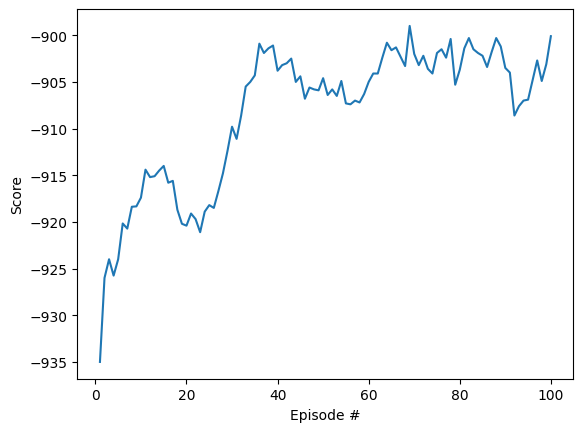

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

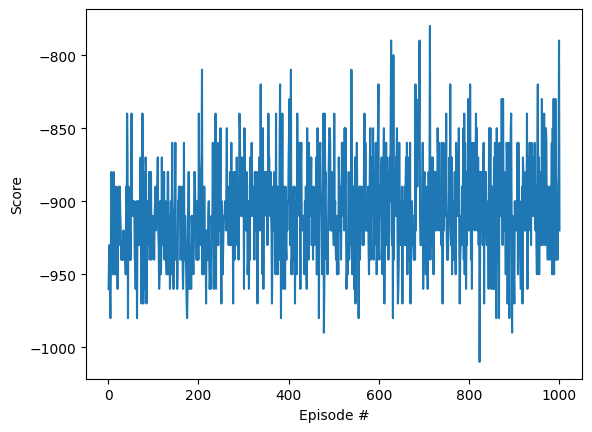

In [ ]:
#gamma = 0.9, reward of action 0: 1 - 0.1*state[4], reward of action 1: 5 if state[4] <=5 else 10, reward of failure: -50
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

[(1, 20), (2, 20), (3, 17), (4, 20), (5, 20), (6, 20), (7, 20), (8, 22), (9, 20), (10, 20), (11, 22), (12, 45), (13, 23), (14, 20), (15, 20), (16, 20), (17, 20), (18, 20), (19, 19), (20, 20), (21, 20), (22, 19), (23, 38), (24, 20), (25, 20), (26, 20), (27, 20), (28, 20), (29, 18), (30, 19), (31, 20), (32, 20), (33, 29), (34, 20), (35, 20), (36, 18), (37, 33), (38, 20), (39, 20), (40, 20), (41, 20), (42, 20), (43, 23), (44, 20), (45, 20), (46, 20), (47, 20), (48, 20), (49, 20), (50, 20), (51, 20), (52, 20), (53, 20), (54, 43), (55, 20), (56, 20), (57, 20), (58, 25), (59, 26), (60, 20), (61, 20), (62, 20), (63, 19), (64, 19), (65, 19), (66, 20), (67, 20), (68, 21), (69, 20), (70, 20), (71, 20), (72, 19), (73, 19), (74, 20), (75, 35), (76, 20), (77, 20), (78, 39), (79, 40), (80, 20), (81, 20), (82, 35), (83, 20), (84, 20), (85, 19), (86, 24), (87, 20), (88, 31), (89, 20), (90, 20), (91, 30), (92, 19), (93, 18), (94, 19), (95, 22), (96, 20), (97, 20), (98, 19), (99, 20), (100, 20), (101, 2

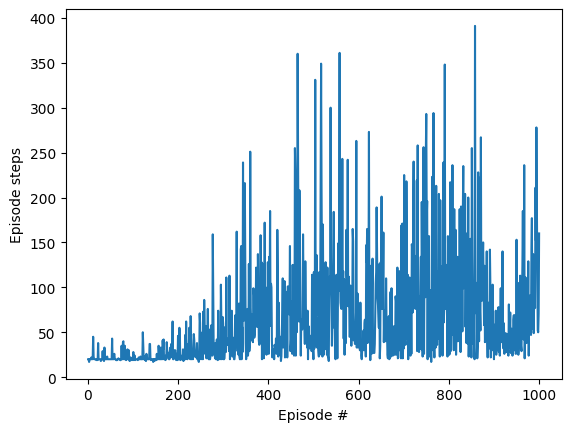

In [ ]:
#gamma = 0.9, reward of action 0: 1 - 0.1*state[4], reward of action 1: 5 if state[4] <=5 else 10, reward of failure: -50
print(t_table)
fig = plt.figure()
ax = fig.add_subplot(111)
iteration = [t_table[i][0] for i in range(len(t_table))]
t = [t_table[i][1] for i in range(len(t_table))]
plt.plot(iteration,t)
plt.ylabel('Episode steps')
plt.xlabel('Episode #')
plt.show()

[21, 21, 18, 21, 21, 21, 21, 22, 21, 21, 22, 43, 23, 21, 21, 21, 21, 21, 20, 21, 21, 20, 37, 21, 21, 21, 21, 21, 19, 20, 21, 21, 28, 21, 21, 19, 32, 21, 21, 21, 21, 21, 23, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 42, 21, 21, 21, 25, 26, 21, 21, 21, 20, 20, 20, 21, 21, 21, 21, 21, 21, 20, 20, 21, 34, 21, 21, 39, 40, 21, 21, 35, 21, 21, 20, 24, 21, 31, 21, 21, 30, 20, 19, 20, 22, 21, 21, 20, 21, 21, 28, 20, 21, 24, 20, 21, 21, 21, 21, 21, 20, 21, 22, 21, 21, 21, 23, 21, 21, 21, 21, 49, 33, 21, 23, 21, 20, 21, 19, 26, 21, 21, 21, 21, 21, 21, 37, 36, 21, 20, 21, 21, 21, 21, 18, 21, 21, 19, 21, 21, 21, 20, 26, 21, 21, 21, 33, 27, 21, 22, 21, 32, 21, 21, 21, 39, 30, 40, 21, 22, 21, 20, 24, 21, 38, 30, 27, 25, 22, 21, 21, 26, 31, 22, 37, 30, 35, 58, 21, 21, 30, 24, 28, 29, 21, 20, 26, 21, 20, 41, 21, 31, 51, 48, 20, 21, 21, 21, 24, 21, 30, 19, 21, 21, 21, 43, 21, 55, 22, 26, 21, 22, 35, 34, 51, 27, 21, 61, 37, 21, 28, 26, 21, 29, 46, 35, 22, 24, 26, 22, 27, 35, 21, 24, 21, 18, 22, 61, 55, 21,

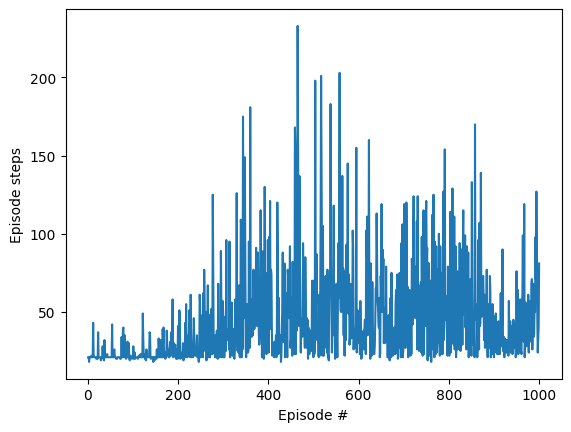

In [ ]:
#gamma = 0.9, reward of action 0: 1 - 0.1*state[4], reward of action 1: 5 if state[4] <=5 else 10, reward of failure: -50
print(action_0_table)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(action_0_table)+1), action_0_table)
plt.ylabel('Episode steps')
plt.xlabel('Episode #')
plt.show()